In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [11]:
# Load the datasets
customers = pd.read_csv("C:/Users/deepa/Downloads/Customers.csv")
products = pd.read_csv("C:/Users/deepa/Downloads/Products.csv")
transactions = pd.read_csv("C:/Users/deepa/Downloads/Transactions.csv")

In [13]:
# Preprocessing Data
def preprocess_for_clustering():
    # Convert date columns to datetime
    customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
    transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

    # Aggregate transaction data
    transaction_features = transactions.groupby('CustomerID').agg({
        'TotalValue': 'sum',            # Total spending by customer
        'Quantity': 'sum',              # Total quantity purchased
        'TransactionID': 'count'        # Number of transactions
    }).rename(columns={
        'TotalValue': 'TotalSpent',
        'Quantity': 'TotalQuantity',
        'TransactionID': 'TransactionCount'
    })

    # Merge with customer profiles
    customer_data = customers.merge(transaction_features, on='CustomerID', how='left')

    # Handle missing values by filling with 0 (assumes no transactions for missing customers)
    customer_data.fillna(0, inplace=True)

    # Encode categorical data (Region)
    le = LabelEncoder()
    customer_data['Region'] = le.fit_transform(customer_data['Region'])

    # Drop unnecessary columns
    features = customer_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features, customer_data

scaled_features, customer_data = preprocess_for_clustering()

In [15]:
# Perform Clustering
def perform_clustering(data, max_clusters=10):
    cluster_results = {}
    db_scores = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        db_index = davies_bouldin_score(data, labels)
        db_scores.append(db_index)
        cluster_results[k] = {
            'model': kmeans,
            'labels': labels,
            'db_index': db_index
        }

    return cluster_results, db_scores

cluster_results, db_scores = perform_clustering(scaled_features)

C:\Users\deepa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\deepa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\deepa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\deepa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

In [17]:
# Choose the optimal number of clusters (lowest DB Index)
optimal_k = min(cluster_results, key=lambda k: cluster_results[k]['db_index'])
optimal_model = cluster_results[optimal_k]['model']
customer_data['Cluster'] = cluster_results[optimal_k]['labels']

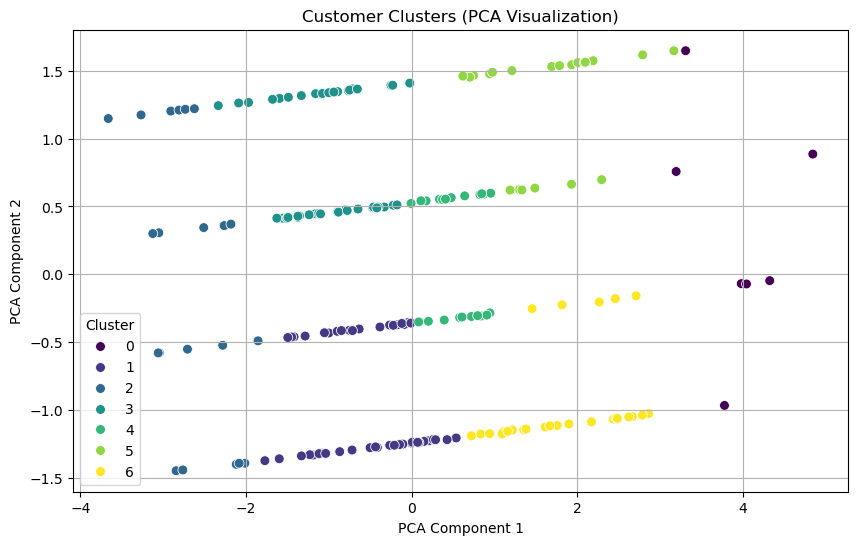

In [19]:
# Visualize Clusters using PCA
def visualize_clusters(data, labels):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', s=50)
    plt.title('Customer Clusters (PCA Visualization)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

visualize_clusters(scaled_features, customer_data['Cluster'])

In [21]:
# Report Clustering Results
print("Clustering Results:")
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"DB Index for Optimal Clusters: {cluster_results[optimal_k]['db_index']:.4f}")

Clustering Results:
Optimal Number of Clusters: 7
DB Index for Optimal Clusters: 0.9969


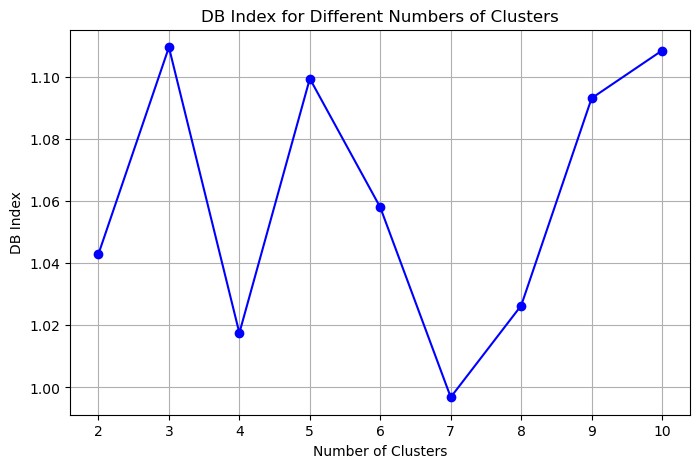

In [25]:
# Plot DB Index for Each Cluster Count
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(db_scores) + 2), db_scores, marker='o', color='blue')
plt.title('DB Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.grid(True)
plt.show()